In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine, load_digits

In [2]:
# plt.style.use('seaborn-darkgrid')
plt.style.use(["dark_background"])
plt.rcParams["figure.figsize"] = [22.0, 8.0]

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    # your code here
    if isinstance(X, pd.core.frame.DataFrame):
        X = X.values
    return (X - X.mean(axis=0)) / X.std(axis=0)

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin


class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.mean_ = None
        self.std_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
        if isinstance(X, list):
            X = np.array(X)
        if self.with_mean:
            self.mean_ = X.mean(axis=0)
        if self.with_std:
            self.std_ = X.std(axis=0)
        return self

    def transform(self, X, y=None, copy=None):
        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
        if isinstance(X, list):
            X = np.array(X)
        if self.with_mean:
            X = X - self.mean_
        if self.with_std:
            X = X / self.std_
        return X


In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ -4.58406557,  -1.41578634],
       [  6.37310694,   0.03359526],
       [  2.44751421,  -0.33336394],
       ...,
       [-12.59836631,   3.67042952],
       [  4.78987078,   4.1397139 ],
       [  0.62887   ,   4.41888085]])

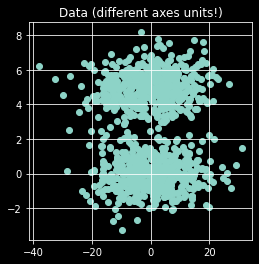

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

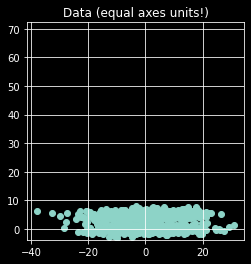

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

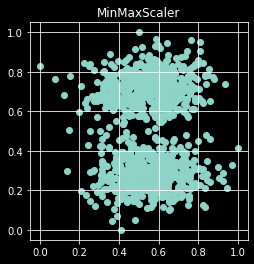

In [12]:
## your code
data = MinMaxScaler().fit_transform(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, title="MinMaxScaler")

### StandardScaler (0.5 point)

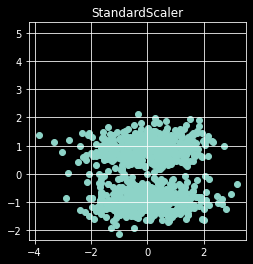

In [13]:
## your code
data = StandardScaler().fit_transform(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, title="StandardScaler")

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


KMeans(n_clusters=2)

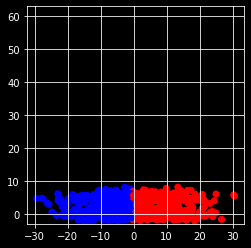

In [14]:
## your code
from sklearn.cluster import KMeans
feature_0 = np.random.randn(1000) * 10
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
Kmean = KMeans(n_clusters=2)
Kmean.fit(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, title=None, clusters=Kmean.labels_)

KMeans(n_clusters=2)

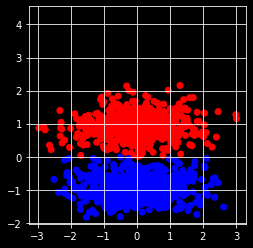

In [15]:
Kmean = KMeans(n_clusters=2)
data = MinMaxScaler().fit_transform(data)
data = StandardScaler().fit_transform(data)
Kmean.fit(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, title=None, clusters=Kmean.labels_)

In [16]:
# Ненормализованные данные дают нам горизонтальную полоску и наверное это причина, почему KMeans делит 
# их на левую и правую половинки. Расстояния по горизонтали получаются выше чем, по вертикали. После 
# нормализации получается соотношение близкое к квадрату и видимо этого оказывается достаточно, 
# чтобы KMeans сделал видимое глазами разделение на верхнюю и нижнюю части.

## Exercise  3 - Preprocessing Pipeline (2 points)

In [17]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(
    wine_data, wine_labels, test_size=0.3, random_state=42
)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [18]:
## your code
from sklearn.feature_selection import SelectKBest, f_classif

def get_score(pipeline):
    score_cv = cross_val_score(pipeline, wine_train, wine_labels_train, cv=4, scoring="accuracy")
    _ = pipeline.fit(wine_train, wine_labels_train)
    return score_cv.mean(), accuracy_score(y_pred=pipeline.predict(wine_val), y_true=wine_labels_val)

scores = []
lr = LogisticRegression(random_state=7, solver="liblinear", penalty="l1")
pipeline = make_pipeline(lr)
scores.append(get_score(pipeline))
pipeline = make_pipeline(StandardScaler(), lr)
scores.append(get_score(pipeline))
pipeline = make_pipeline(StandardScaler(), SelectKBest(f_classif, k=4), lr)
scores.append(get_score(pipeline))
print("\n".join("cv: %.3f, val: %.3f" % t for t in scores))
# Добавление нормализации улучшило точность на трейне, но на тесте осталось 0.981. Добавление SelectKBest
# ухудшило результат на трейне, но на тесте получилась 100% точность. Если убрать StandardScaler 
# перед SelectKBest, то точность ухудшится и на трейне и на тесте. Но можно поставить StandardScaler после 
# SelectKBest и будет 100% на тесте.

cv: 0.903, val: 0.981
cv: 0.976, val: 0.981
cv: 0.952, val: 1.000


## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [19]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [20]:
## your code
def cov_vec(a, b):
    # return ((a - np.mean(a)) * (b - np.mean(b))).sum() / (a.shape[0] - 1)
    # mean == 0
    return (a * b).sum() / (a.shape[0] - 1)


def cov(m):
    # m (178, 13)
    n_cols = m.shape[1]
    res = np.zeros((n_cols, n_cols))
    for i in range(n_cols):
        for j in range(n_cols):
            res[i, j] = cov_vec(m[:, i], m[:, j])
    return res


data = StandardScaler().fit_transform(wine_data)
S = cov(data)
assert np.allclose(S, np.cov(data.T))

If your code is correct, the following assert should be Ok.

In [21]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [22]:
from scipy.optimize import minimize


def objective(x):
    # your code
    return -(x @ S @ x)


def norm_constraint(x):
    # your code
    return np.linalg.norm(x) - 1


con1 = {"type": "eq", "fun": norm_constraint}
# x0 = np.random.random(S.shape[1]) # иногда на находит
x0 = np.zeros(S.shape[1])
print("x0.shape", x0.shape, "S.shape", S.shape)
sol = minimize(objective, x0, constraints=[con1])
x0 = -sol.x
# print(f"x0\n{x0}")
# print("x0@S@x0", x0 @ S @ x0)
assert np.allclose(x0 @ S @ x0, 4.732436977583595)
u, s, v = np.linalg.svd(S)
# print(f"svd v[0]\n{v[0]}")
# print(f"svd v[0]\n{v}")
assert np.allclose(x0, v[0], atol=0.0001)

x0.shape (13,) S.shape (13, 13)


Hurray! We have first vector! Let's do another one.

In [23]:
def orthogonality_constraint(x):
    return x @ x0

con2 = {"type": "eq", "fun": orthogonality_constraint}
x1 = np.zeros(S.shape[1])
sol = minimize(objective, x1, constraints=[con1, con2])
x1 = -sol.x
assert np.allclose(x1 @ S @ x1, 2.5110809296451233)
assert np.allclose(x1, v[1], atol=0.0001)

If your solution is correct, the following asserts should be Ok.

In [24]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

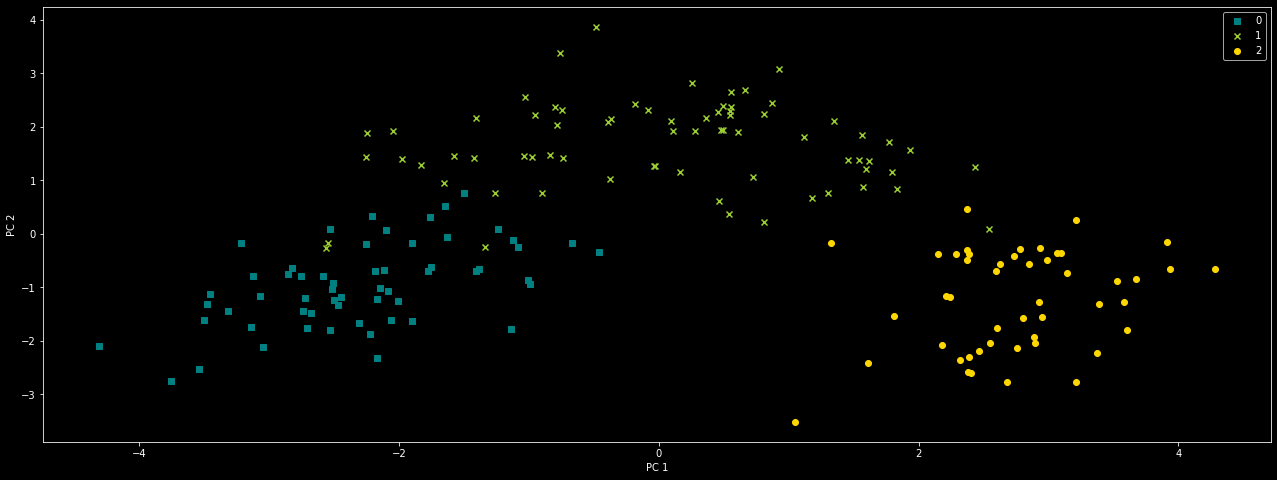

In [25]:
# nice article
# https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad
w = np.hstack((x0[:, np.newaxis], x1[:, np.newaxis]))
data_pca = data @ w
colors = ["teal", "yellowgreen", "gold"]
markers = ["s", "x", "o"]
for l, c, m in zip(np.unique(wine_labels), colors, markers):
    _ = plt.scatter(data_pca[wine_labels == l, 0], data_pca[wine_labels == l, 1], c=c, label=l, marker=m)
_ = plt.xlabel("PC 1")
_ = plt.ylabel("PC 2")
_ = plt.legend(loc="best")
plt.show()

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [26]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

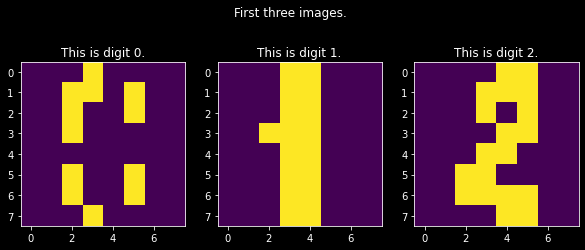

In [27]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    _ = ax[i].imshow(X.iloc[i].values.reshape(8,8))
    _ = ax[i].set_title(f"This is digit {y[i]}.")
_= plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [28]:
## your code here
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [30]:
clf = RandomForestClassifier(max_depth=13)
# your code here
clf.fit(X_train, y_train)
acc = clf.score(X_val, y_val)
print(acc)

RandomForestClassifier(max_depth=13)

0.9876543209876543


In [31]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [32]:
# ! pip install boruta

In [33]:
from boruta import BorutaPy

feat_selector = BorutaPy(
    RandomForestClassifier(max_depth=13), n_estimators="auto", verbose=0, max_iter=100, random_state=42
)
# your code here: do run the boruta
feat_selector.fit(X.values, y.values)

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=63,
                                          random_state=RandomState(MT19937) at 0x3EA0EEB8),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x3EA0EEB8)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

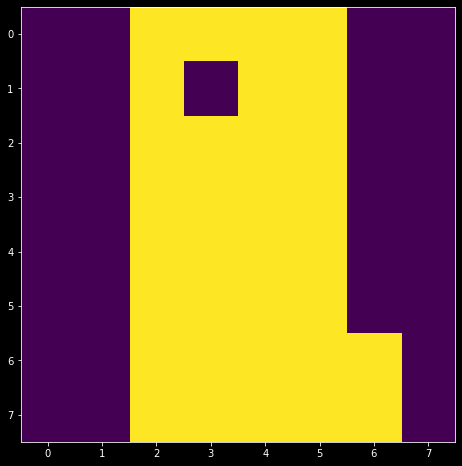

In [34]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [35]:
X_train_filtered = feat_selector.transform(X_train.values)
X_train.shape, X_train_filtered.shape
X_val_filtered = feat_selector.transform(X_val.values)
X_val.shape, X_val_filtered.shape, 

((375, 64), (375, 33))

((162, 64), (162, 33))

In [36]:
clf = RandomForestClassifier(max_depth=13, random_state=15)
# your code here
clf.fit(X_train_filtered, y_train)
acc = clf.score(X_val_filtered, y_val)
print(acc)

RandomForestClassifier(max_depth=13, random_state=15)

0.9938271604938271


In [37]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market